In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib import cm

In [19]:
import random
np.random.seed(13337)

In [20]:
def brownian(T, dt, M):
    ''' 
    Generate a brownian path with from 0 to T with time step dt
    
    Based on:
        X(t+dt) = X(t) + N(0, delta**2 * dt)

    Code adapted from:
    "https://scipy-cookbook.readthedocs.io/items/BrownianMotion.html"

    Parameters
    ----------
    T : float
        Final time of the brownian path
    dt : float
        Time step of the brownian path
    M : int
        Number of paths to generate
    '''

    K = int(T/dt)
    X = np.zeros((M, K+1))

    # Create the increments of the brownian motion
    r = norm.rvs(size=(M, K), scale=np.sqrt(dt))
    
    # Cumulative sum of the random numbers
    X[:, 1:] = np.cumsum(r, axis=1)

    return X.T

In [21]:
def geometric_brownian_motion(x0, T, dt, sigma, mu, M):
    brownian_path = brownian(T, dt, M)
    return x0 * np.exp((mu - 0.5 * sigma**2) * dt + sigma * brownian_path)

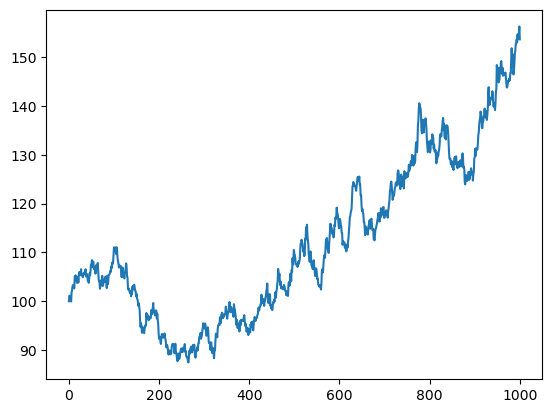

In [22]:
#test
S0 = 100
T = 1
dt = 0.001
sigma = 0.3
mu = 0.1
M = 1

#brownian_path = brownian(x0, T, dt, sigma)
gbm_path = geometric_brownian_motion(S0, T, dt, sigma, mu, M)

plt.plot(gbm_path)
plt.show()

In [23]:
def bs_option(S0, strike, T, r, sigma, type):
    '''
    Black-Scholes option pricing formula

    Parameters
    ----------
    S0 : float
        Initial value of the underlying
    strike : float
        Strike price of the option
    T : float
        Time to maturity of the option
    r : float
        Risk-free interest rate
    sigma : float
        Volatility of the underlying
    type : str
        Type of option, either 'call' or 'put'
    '''
    d1 = (np.log(S0/strike) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if type == 'call':
        return S0 * norm.cdf(d1) - strike * np.exp(-r * T) * norm.cdf(d2)
    elif type == 'put':
        return strike * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    else:
        raise ValueError('Option type must be either "call" or "put"')

In [24]:
# test if fulfills put-call parity
S0 = 100
strike = 100
T = 1
r = 0.05
sigma = 0.3

call = bs_option(S0, strike, T, r, sigma, 'call')
put = bs_option(S0, strike, T, r, sigma, 'put')

print(call - put - (S0 - strike * np.exp(-r * T)))

-7.105427357601002e-15


In [25]:
def bs_delta(S0, strike, T, r, sigma, type):
    '''
    Black-Scholes delta

    Parameters
    ----------
    S0 : float
        Initial value of the underlying
    strike : float
        Strike price of the option
    T : float
        Time to maturity of the option
    r : float
        Risk-free interest rate
    sigma : float
        Volatility of the underlying
    type : str
        Type of option, either 'call' or 'put'
    '''
    d1 = (np.log(S0/strike) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))

    if type == 'call':
        return norm.cdf(d1)
    elif type == 'put':
        return norm.cdf(d1) - 1
    else:
        raise ValueError('Option type must be either "call" or "put"')

In [26]:
# test deltas for call and put
S0 = 100
strike = 100
T = 1
r = 0.05
sigma = 0.3

call_delta = bs_delta(S0, strike, T, r, sigma, 'call')
put_delta = bs_delta(S0, strike, T, r, sigma, 'put')

print(call_delta)
print(put_delta)
print(call_delta - put_delta)

0.6242517279060125
-0.37574827209398753
1.0


/var/folders/v_/g8cn51c96_l31y5zbwlvt2j00000gp/T/ipykernel_7787/1697056455.py:20: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S0/strike) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


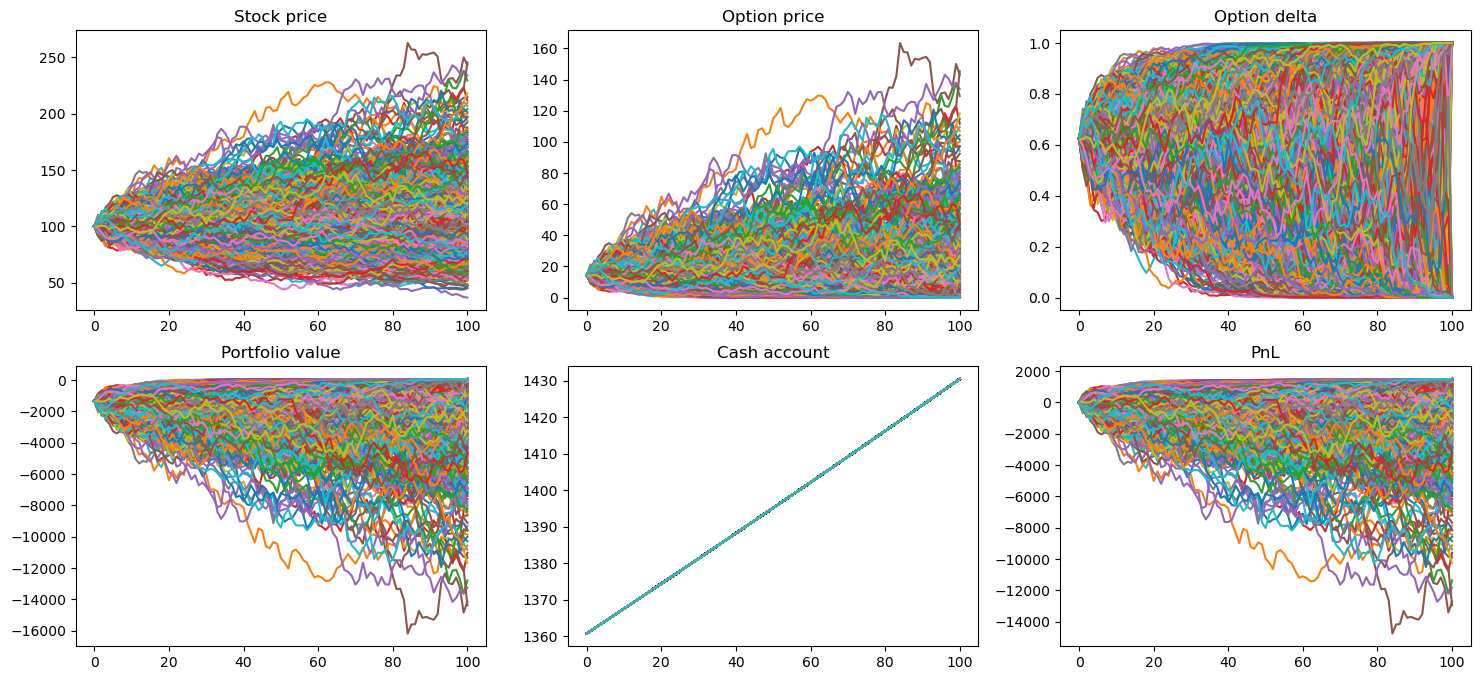

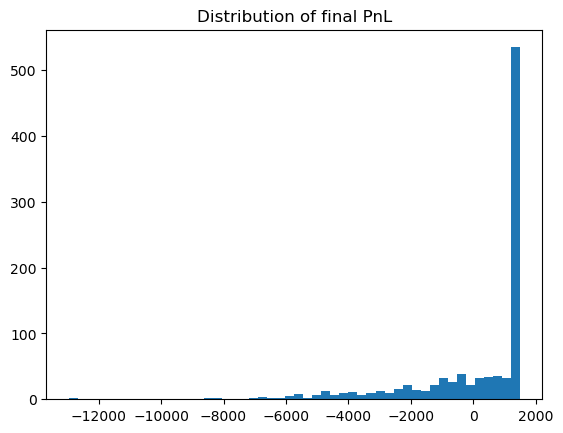

In [27]:
# Example
# Delta hedging a call option
# Sell a call and delta hedge
# No rebalancing
# No transaction costs

# Parameters
S0 = 100
strike = 100
T = 1
r = 0.05
sigma = 0.3
dt = 0.01
M = 1000

# Generate the brownian path
stock_path = geometric_brownian_motion(S0, T, dt, sigma, r, M)

# Generate the initial option price
option_price = bs_option(S0, strike, T, r, sigma, 'call')

# Generate the initial delta
initial_delta = bs_delta(S0, strike, T, r, sigma, 'call')

# Generate the cash account
cash = np.zeros(stock_path.shape)

# Generate the portfolio value
portfolio = np.zeros(stock_path.shape)

# PnL
pnl = np.zeros(stock_path.shape)

# initial cash is the option price * 100 - delta * S0
cash[0] = option_price * 100 - initial_delta * S0

# initial portfolio value is the - option price * 100 + delta * S0
portfolio[0] = - option_price * 100 + initial_delta * S0

option_path = np.zeros(stock_path.shape)
option_path[0] = option_price
option_delta = np.zeros(stock_path.shape)
option_delta[0] = initial_delta

for t in range(1, len(stock_path)):
    # Update the stock price
    stock_price = stock_path[t]

    # Update the option price
    option_price = bs_option(stock_price, strike, T - t * dt, r, sigma, 'call')
    option_path[t] = option_price

    # Update the delta
    delta = bs_delta(stock_price, strike, T - t * dt, r, sigma, 'call')
    option_delta[t] = delta

    # Update the portfolio value
    portfolio[t] = - option_price * 100 + initial_delta * stock_price

    # Update the cash account
    cash[t] = cash[t-1] * np.exp(r * dt)

    # Update the PnL
    pnl[t] = portfolio[t] + cash[t]

# Plot the PnL, cash account and portfolio value
# Plot in separate figure the stock price and option price
fig, ax = plt.subplots(2, 3, figsize=(18, 8))

ax[0, 0].plot(stock_path)
ax[0, 0].set_title('Stock price')

ax[0, 1].plot(option_path)
ax[0, 1].set_title('Option price')

ax[0, 2].plot(option_delta)
ax[0, 2].set_title('Option delta')

ax[1, 0].plot(portfolio)
ax[1, 0].set_title('Portfolio value')

ax[1, 1].plot(cash)
ax[1, 1].set_title('Cash account')

ax[1, 2].plot(pnl)
ax[1, 2].set_title('PnL')

plt.show()


# check distribution of final PnL
plt.hist(pnl[-1], bins=50)
plt.title('Distribution of final PnL')
plt.show()

In [28]:
print(pnl[-1].mean(),pnl[-1].std(),pnl[-1].max(),pnl[-1].min())

22.403606641916486 2308.616687316538 1492.8780309550827 -12954.466651854687


/var/folders/v_/g8cn51c96_l31y5zbwlvt2j00000gp/T/ipykernel_7787/1697056455.py:20: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S0/strike) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


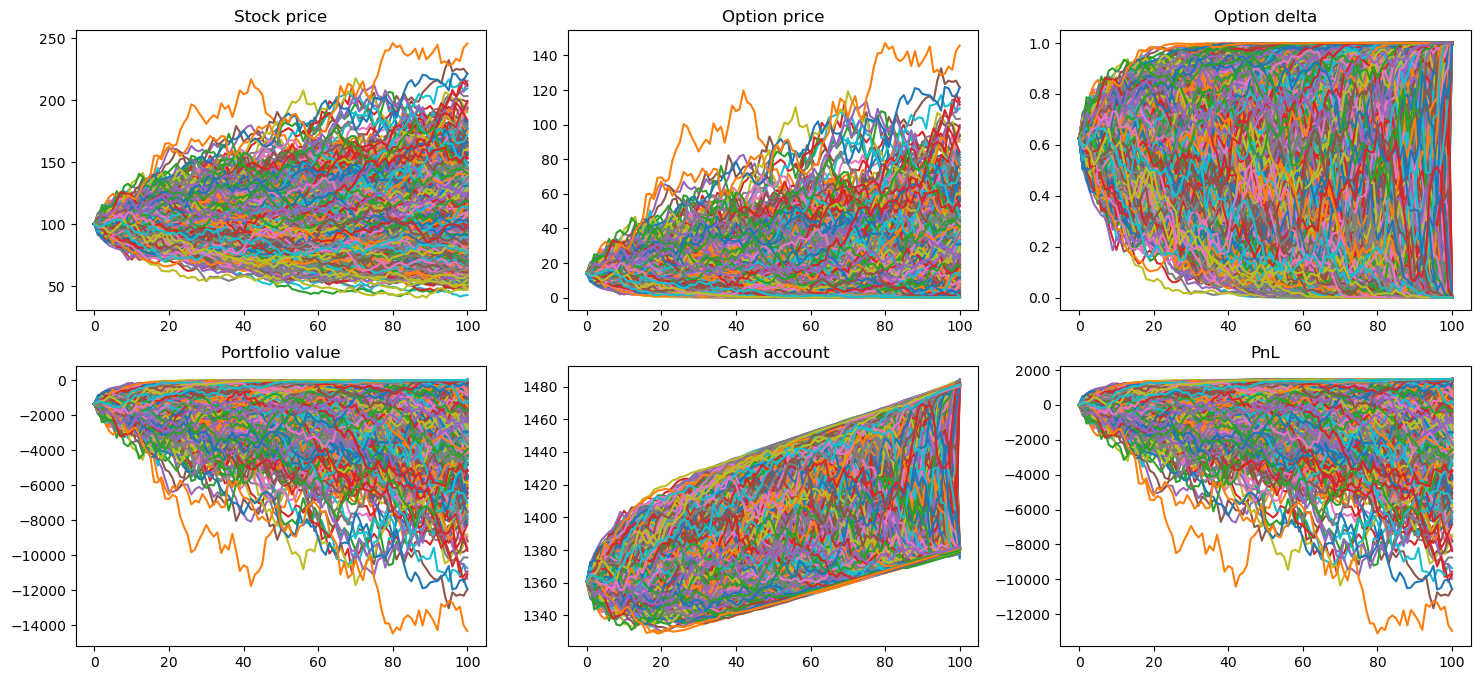

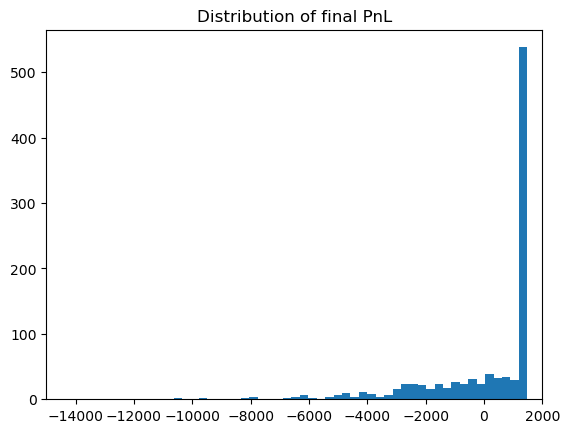

In [29]:
# Example
# Delta hedging a call option
# Sell a call and delta hedge
# Rebalance at every time step
# No transaction costs

# Parameters
S0 = 100
strike = 100
T = 1
r = 0.05
sigma = 0.3
dt = 0.01
M = 1000

# Generate the brownian path
stock_path = geometric_brownian_motion(S0, T, dt, sigma, r, M)

# Generate the initial option price
option_price = bs_option(S0, strike, T, r, sigma, 'call')

# Generate the initial delta
delta = bs_delta(S0, strike, T, r, sigma, 'call')

# Generate the cash account
cash = np.zeros(stock_path.shape)

# Generate the portfolio value
portfolio = np.zeros(stock_path.shape)

# PnL
pnl = np.zeros(stock_path.shape)

# initial cash is the option price * 100 - delta * S0
cash[0] = option_price * 100 - delta * S0

# initial portfolio value is the - option price * 100 + delta * S0
portfolio[0] = - option_price * 100 + delta * S0

option_path = np.zeros(stock_path.shape)
option_path[0] = option_price
option_delta = np.zeros(stock_path.shape)
option_delta[0] = delta

for t in range(1, len(stock_path)):
    # Update the stock price
    stock_price = stock_path[t]

    # Update the option price
    option_price = bs_option(stock_price, strike, T - t * dt, r, sigma, 'call')
    option_path[t] = option_price

    # Update the delta
    delta = bs_delta(stock_price, strike, T - t * dt, r, sigma, 'call')
    option_delta[t] = delta

    # Update the portfolio value
    portfolio[t] = - option_price * 100 + delta * stock_price

    # Update the cash account
    cash[t] = cash[t-1] * np.exp(r * dt) - (delta - option_delta[t-1]) * stock_price

    # Update the PnL
    pnl[t] = portfolio[t] + cash[t]

# Plot the PnL, cash account and portfolio value
# Plot in separate figure the stock price and option price
fig, ax = plt.subplots(2, 3, figsize=(18, 8))

ax[0, 0].plot(stock_path)
ax[0, 0].set_title('Stock price')

ax[0, 1].plot(option_path)
ax[0, 1].set_title('Option price')

ax[0, 2].plot(option_delta)
ax[0, 2].set_title('Option delta')

ax[1, 0].plot(portfolio)
ax[1, 0].set_title('Portfolio value')

ax[1, 1].plot(cash)
ax[1, 1].set_title('Cash account')

ax[1, 2].plot(pnl)
ax[1, 2].set_title('PnL')

plt.show()


# check distribution of final PnL
plt.hist(pnl[-1], bins=50)
plt.title('Distribution of final PnL')
plt.xlim(-15000, 2000)
plt.show()

In [30]:
print(pnl[-1].mean(),pnl[-1].std(),pnl[-1].max(),pnl[-1].min())

41.9268249134136 2220.5849794690293 1484.6521107917283 -12951.615323577877


/var/folders/v_/g8cn51c96_l31y5zbwlvt2j00000gp/T/ipykernel_7787/1697056455.py:20: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S0/strike) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


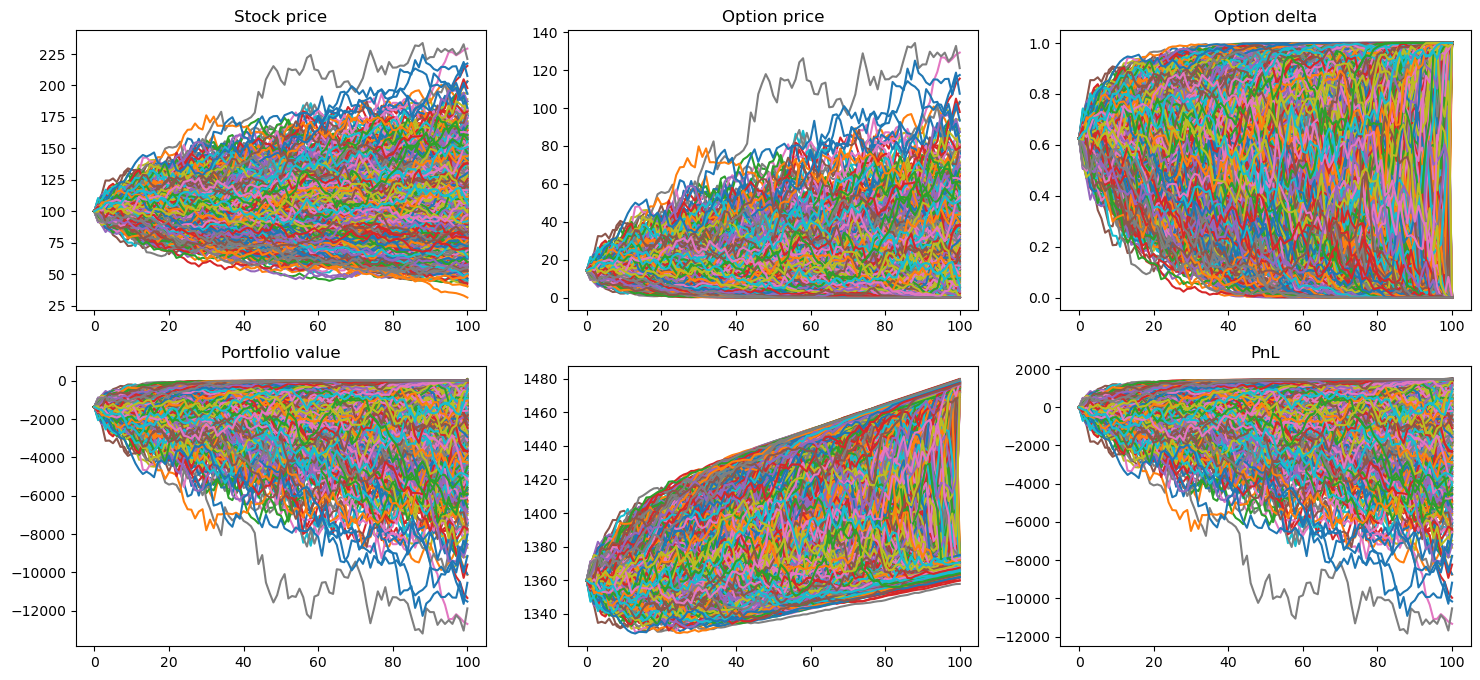

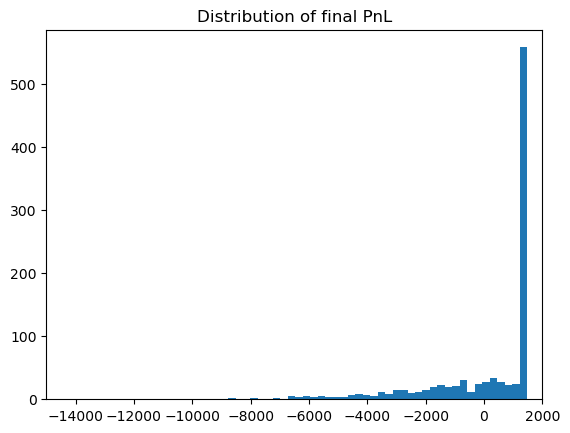

In [31]:
# Example
# Delta hedging a call option
# Sell a call and delta hedge
# Rebalance at every time step
# With fixed transaction costs (stock & option)

# Parameters
S0 = 100
strike = 100
T = 1
r = 0.05
sigma = 0.3
dt = 0.01
M = 1000
stock_cost = 0.01 * 0.02    # 1 basis point of the stock price
option_cost = 0.01 * 0.05   # 5 basis points of the option price

# Generate the brownian path
stock_path = geometric_brownian_motion(S0, T, dt, sigma, r, M)

# Generate the initial option price
option_price = bs_option(S0, strike, T, r, sigma, 'call')

# Generate the initial delta
delta = bs_delta(S0, strike, T, r, sigma, 'call')

# Generate the cash account
cash = np.zeros(stock_path.shape)

# Generate the portfolio value
portfolio = np.zeros(stock_path.shape)

# PnL
pnl = np.zeros(stock_path.shape)

# initial cash is the option price * 100 - delta * S0
cash[0] = option_price * 100 - delta * S0 - stock_cost * delta * S0 - option_cost * option_price * 100

# initial portfolio value is the - option price * 100 + delta * S0
portfolio[0] = - option_price * 100 + delta * S0

option_path = np.zeros(stock_path.shape)
option_path[0] = option_price
option_delta = np.zeros(stock_path.shape)
option_delta[0] = delta

for t in range(1, len(stock_path)):
    # Update the stock price
    stock_price = stock_path[t]

    # Update the option price
    option_price = bs_option(stock_price, strike, T - t * dt, r, sigma, 'call')
    option_path[t] = option_price

    # Update the delta
    delta = bs_delta(stock_price, strike, T - t * dt, r, sigma, 'call')
    option_delta[t] = delta

    # Update the portfolio value
    portfolio[t] = - option_price * 100 + delta * stock_price

    # Update the cash account
    cash[t] = cash[t-1] * np.exp(r * dt) - (delta - option_delta[t-1]) * stock_price - stock_cost * np.abs(delta - option_delta[t-1]) * stock_price - option_cost * np.abs(option_price - option_path[t-1]) * 100

    # Update the PnL
    pnl[t] = portfolio[t] + cash[t]

# Plot the PnL, cash account and portfolio value
# Plot in separate figure the stock price and option price
fig, ax = plt.subplots(2, 3, figsize=(18, 8))

ax[0, 0].plot(stock_path)
ax[0, 0].set_title('Stock price')

ax[0, 1].plot(option_path)
ax[0, 1].set_title('Option price')

ax[0, 2].plot(option_delta)
ax[0, 2].set_title('Option delta')

ax[1, 0].plot(portfolio)
ax[1, 0].set_title('Portfolio value')

ax[1, 1].plot(cash)
ax[1, 1].set_title('Cash account')

ax[1, 2].plot(pnl)
ax[1, 2].set_title('PnL')

plt.show()


# check distribution of final PnL
plt.hist(pnl[-1], bins=50)
plt.title('Distribution of final PnL')
plt.xlim(-15000, 2000)
plt.show()

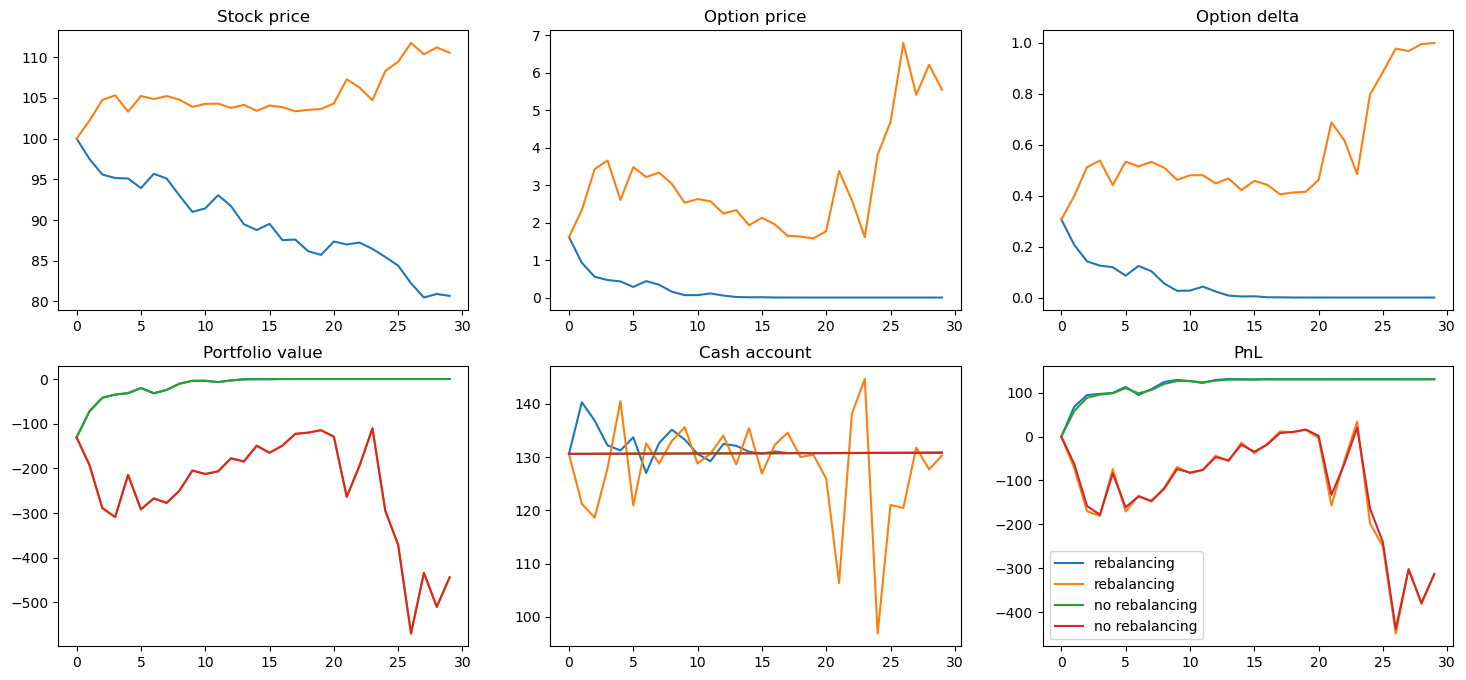

Final PnL without rebalancing:  [ 130.81802562 -313.18350193]
Final PnL with rebalancing:  [ 130.81307717 -313.69725056]


In [32]:
# compare the two strategies
# on one path

# Parameters
S0 = 100
strike = 105
T = 30/365
r = 0.02
sigma = 0.3
dt = 1/365
M = 2
stock_cost = 0.01 * 0.02    # 2 basis points of the stock price
option_cost = 0.01 * 0.05   # 5 basis points of the option price


# Generate the stock path
stock_path = geometric_brownian_motion(S0, T, dt, sigma, r, M)

# Generate the initial option price
option_price = bs_option(S0, strike, T, r, sigma, 'call')

# Generate the initial delta
delta = bs_delta(S0, strike, T, r, sigma, 'call')

# Generate the cash account
cash_no_rebalancing = np.zeros(stock_path.shape)
cash_rebalancing = np.zeros(stock_path.shape)

# Generate the portfolio value
portfolio_no_rebalancing = np.zeros(stock_path.shape)
portfolio_rebalancing = np.zeros(stock_path.shape)

# PnL
pnl_no_rebalancing = np.zeros(stock_path.shape)
pnl_rebalancing = np.zeros(stock_path.shape)

# initial cash is the option price * 100 - delta * S0
cash_no_rebalancing[0] = option_price * 100 - delta * S0 - stock_cost * delta * S0 - option_cost * option_price * 100
cash_rebalancing[0] = option_price * 100 - delta * S0 - stock_cost * delta * S0 - option_cost * option_price * 100

# initial portfolio value is the - option price * 100 + delta * S0
portfolio_no_rebalancing[0] = - option_price * 100 + delta * S0
portfolio_rebalancing[0] = - option_price * 100 + delta * S0

option_path = np.zeros(stock_path.shape)
option_path[0] = option_price
option_delta = np.zeros(stock_path.shape)
option_delta[0] = delta

for t in range(1, len(stock_path)):
    # Update the stock price
    stock_price = stock_path[t]

    # Update the option price
    option_price = bs_option(stock_price, strike, T - t * dt, r, sigma, 'call')
    option_path[t] = option_price

    # Update the delta
    delta = bs_delta(stock_price, strike, T - t * dt, r, sigma, 'call')
    option_delta[t] = delta

    # Update the portfolio value
    portfolio_no_rebalancing[t] = - option_price * 100 + delta * stock_price
    portfolio_rebalancing[t] = - option_price * 100 + delta * stock_price

    # Update the cash account
    cash_no_rebalancing[t] = cash_no_rebalancing[t-1] * np.exp(r * dt)
    cash_rebalancing[t] = cash_no_rebalancing[t-1] * np.exp(r * dt) - (delta - option_delta[t-1]) * stock_price - stock_cost * np.abs(option_delta[0] - option_delta[t-1]) * stock_price - option_cost * np.abs(option_price - option_path[t-1]) * 100

    # Update the PnL
    pnl_no_rebalancing[t] = portfolio_no_rebalancing[t] + cash_no_rebalancing[t]
    pnl_rebalancing[t] = portfolio_rebalancing[t] + cash_rebalancing[t]

# Plot the PnL, cash account and portfolio value
# Plot in separate figure the stock price and option price
fig, ax = plt.subplots(2, 3, figsize=(18, 8))

ax[0, 0].plot(stock_path)
ax[0, 0].set_title('Stock price')

ax[0, 1].plot(option_path)
ax[0, 1].set_title('Option price')

ax[0, 2].plot(option_delta)
ax[0, 2].set_title('Option delta')

ax[1, 0].plot(portfolio_rebalancing, label='rebalancing')
ax[1, 0].plot(portfolio_no_rebalancing, label='no rebalancing')
ax[1, 0].set_title('Portfolio value')

ax[1, 1].plot(cash_rebalancing, label='rebalancing')
ax[1, 1].plot(cash_no_rebalancing, label='no rebalancing')
ax[1, 1].set_title('Cash account')

ax[1, 2].plot(pnl_rebalancing, label='rebalancing')
ax[1, 2].plot(pnl_no_rebalancing, label='no rebalancing')
ax[1, 2].set_title('PnL')

plt.legend()
plt.show()

print("Final PnL without rebalancing: ", pnl_no_rebalancing[-1])
print("Final PnL with rebalancing: ", pnl_rebalancing[-1])

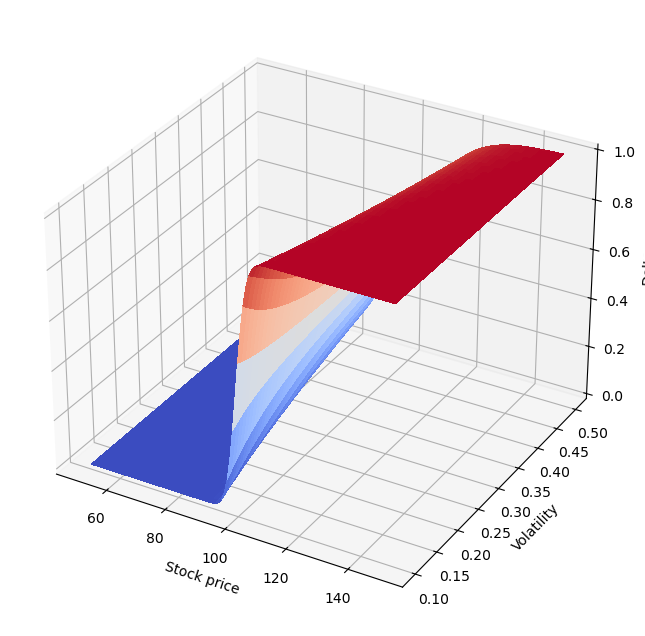

In [33]:
# let's get a bit more hands on with delta
# we want to see how delta changes with respect to the stock price and volatility

# Parameters
S0 = 100
strike = 100
T = 30/365
r = 0.02
sigma = 0.2
dt = 1/365
M = 1

delta = bs_delta(S0, strike, T, r, sigma, 'call')

# plot surface of delta with respect to stock price and volatility
# we will use the same parameters as before, but we will vary the stock price and volatility

S0 = np.linspace(50, 150, 100)
sigma = np.linspace(0.1, 0.5, 100)

S0, sigma = np.meshgrid(S0, sigma)

delta = bs_delta(S0, strike, T, r, sigma, 'call')

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8, 8))
surf = ax.plot_surface(S0, sigma, delta, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('Stock price')
ax.set_ylabel('Volatility')
ax.set_zlabel('Delta')
plt.show()


In [34]:
# testing Teichmann notebook parameters

S0 = 1
T = 1
strike = 1
sigma = 0.2
r = 0
dt = 1/100

bs_option(S0, strike, T, r, sigma, 'call')

0.07965567455405798